# Assigment 2 - Forecasting Electricity Prices

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import model_selection
from math import sqrt
import warnings
import numpy as np
import os
import pandas as pd
import datetime as dt

warnings.filterwarnings("ignore")

In [89]:
# Prøver lige noget fancy gpu acceleration

import torch
import torch.nn as nn

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

No GPU available. Training will run on CPU.
cpu


Loading in required data, and filtering according to requirements.

In [90]:
file_P = os.path.join(os.getcwd(),'data/Elspotprices2.csv')
df_prices = pd.read_csv(file_P)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

## Task 1

### 1.1

We start by dividing the data into training- and test sets.

In [91]:
# We use the time intervial.
t_s_data = pd.Timestamp(dt.datetime(2019, 1, 1, 0, 0, 0))
t_e_data = pd.Timestamp(dt.datetime(2023, 1, 1, 0, 0, 0))

data_all = df_prices.loc[(df_prices['HourUTC'] >= t_s_data) & (df_prices['HourUTC'] <= t_e_data)]
data_all = data_all.reset_index(drop=True)

# We use the time intervial.
t_s_train = pd.Timestamp(dt.datetime(2023, 1, 1, 0, 0, 0))
t_e_train = pd.Timestamp(dt.datetime(2023, 11, 30, 23, 0, 0))

train = df_prices.loc[(df_prices['HourUTC'] >= t_s_train) & (df_prices['HourUTC'] <= t_e_train)]
train = train.reset_index(drop=True)

t_s_test = pd.Timestamp(dt.datetime(2023, 12, 1, 0, 0, 0))
t_e_test= pd.Timestamp(dt.datetime(2023, 12, 31, 23, 0, 0))

test = df_prices.loc[(df_prices['HourUTC'] >= t_s_test) & (df_prices['HourUTC'] <= t_e_test)]
test = test.reset_index(drop=True)

Visualizing the sets along with past data

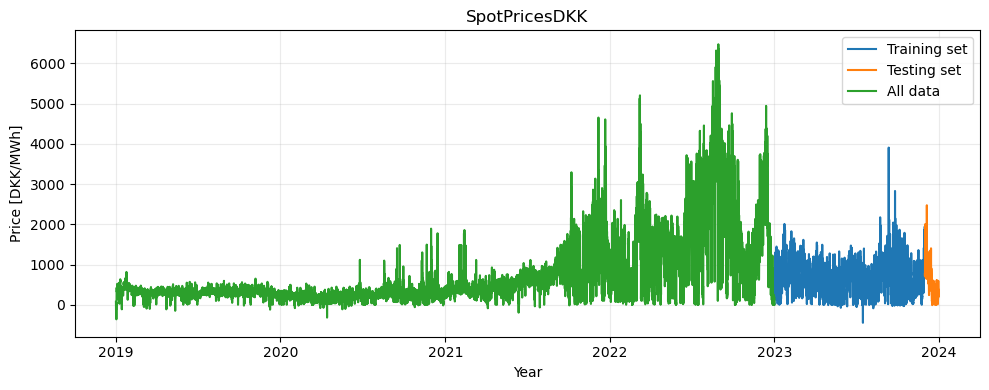

In [54]:

plt.figure(figsize=(10, 4), dpi=100)

plt.plot(train['HourUTC'], train['SpotPriceDKK'])
plt.plot(test['HourUTC'], test['SpotPriceDKK'])
plt.plot(data_all['HourUTC'], data_all['SpotPriceDKK'], alpha=1)


plt.title('SpotPricesDKK')
plt.xlabel('Year')
plt.ylabel('Price [DKK/MWh]')

plt.legend(["Training set", "Testing set" , "All data"])
plt.tight_layout()
plt.grid(alpha=0.25)
plt.show()

We will first remove all the columns other than the numerical values for SpotPricesDKK.
We use auto_arima to automatically determine ARIMA parameters.

In [7]:
train_Arima = train['SpotPriceDKK']
test_Arima = test['SpotPriceDKK']

# Automatically fit the ARIMA model
# model = pm.auto_arima(train_Arima, seasonal = True, trace = True, maxiter = 15, stepwise = True, method = 'nm', m = 24)
model = pm.arima.ARIMA(order=(2,1,0), seasonal_order=(1,0,1,24)) 
model.fit(train_Arima)


# Here the optimal model was found through auto_arima(), but later fit manually to save time during testing

ARIMA(order=(2, 1, 0), seasonal_order=(1, 0, 1, 24))

In [8]:
# Day-ahead prediction
pred = []

for i in range(0, len(test_Arima), 24):
    # Predict next 24 values in test set
    pred_temp = model.predict(24)
    pred.extend(pred_temp)
    
    # Update model with actual values for the next 24 time steps in one go
    model.update(test_Arima[i:i+24])

For comparison, a simple persistence model is created.

In [9]:
pers = np.zeros(len(test_Arima)).tolist()

for i in range(24, len(test_Arima), 24):
    for j in range(24):
        pers[i+j] = test_Arima[(i-24)+j]

The test data is plotted along with the ARIMA predictions and the persistence model.

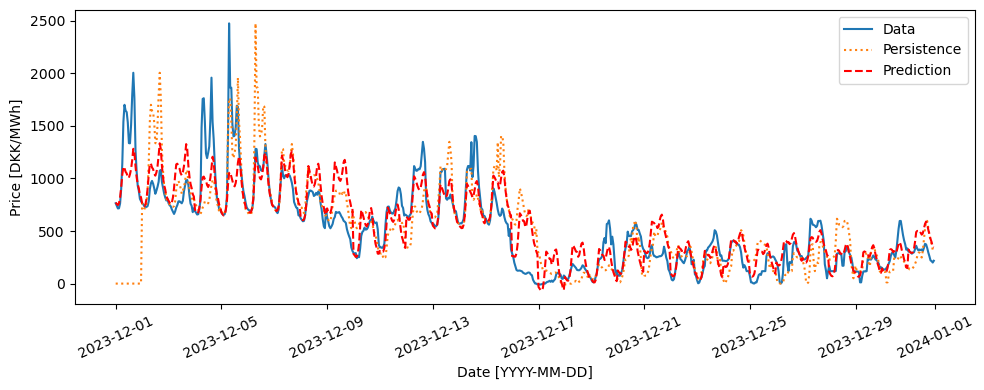

In [34]:
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(test['HourUTC'], test_Arima, label='Data')
plt.plot(test['HourUTC'], pers, label='Persistence', linestyle="dotted")
plt.plot(test['HourUTC'], pred, label='Prediction', linestyle="dashed", color="red")
plt.legend()
plt.ylabel('Price [DKK/MWh]')
plt.xlabel('Date [YYYY-MM-DD]')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

The error metrics for both are calculated.

In [16]:
# Calculate error metrics
RMSE_AR_pred = sqrt(mean_squared_error(test_Arima, pred))
MAE_AR_pred = mean_absolute_error(test_Arima, pred)
print('Prediction')
print('\t Root-mean-square error: ', round(RMSE_AR_pred,2))
print('\t Mean absolute error: ', round(MAE_AR_pred,2))

print('')

RMSE_AR_pers = sqrt(mean_squared_error(test_Arima, pers))
MAE_AR_pers = mean_absolute_error(test_Arima, pers)
print('Persistence')
print('\t Root-mean-square error: ', round(RMSE_AR_pers,2))
print('\t Mean absolute error: ', round(MAE_AR_pers,2))

Prediction
	 Root-mean-square error:  211.6
	 Mean absolute error:  145.57

Persistence
	 Root-mean-square error:  339.24
	 Mean absolute error:  214.76


This shows that the day-ahead prediction with no exogenous variables is a little better than simply assuming the same values as the previous day.

### 1.2

Loading in the data with exogenous variables.

In [92]:
file_P = os.path.join(os.getcwd(),'data/ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.loc[df_data["PriceArea"].isin(["DK2"])]
df_data = df_data.dropna(axis=1)
df_data = df_data.reset_index(drop=True)

In [93]:
# Which variables do we have to choose from?
for col in df_data.columns:
    print(col)

HourUTC
HourDK
PriceArea
CentralPowerMWh
LocalPowerMWh
LocalPowerSelfConMWh
OffshoreWindLt100MW_MWh
OffshoreWindGe100MW_MWh
OnshoreWindLt50kW_MWh
OnshoreWindGe50kW_MWh
HydroPowerMWh
SolarPowerLt10kW_MWh
SolarPowerGe10Lt40kW_MWh
SolarPowerGe40kW_MWh
SolarPowerSelfConMWh
ExchangeSE_MWh
ExchangeGE_MWh
ExchangeGreatBelt_MWh
GrossConsumptionMWh
GridLossTransmissionMWh
PowerToHeatMWh


Choosing exogenous variables

In [94]:
train.insert(2, 'ExchangeSE_MWh', df_data['ExchangeSE_MWh'])
train.insert(3, 'GrossConsumptionMWh', df_data['GrossConsumptionMWh'])
# train.insert(3, 'OnshoreWindGe50kW_MWh', df_data['OnshoreWindGe50kW_MWh'])

train = train.drop(columns=['HourUTC', 'SpotPriceDKK'])

print('Exogenous variables chosen: ')

for col in train.columns:
    print('\t', col)

Exogenous variables chosen: 
	 ExchangeSE_MWh
	 GrossConsumptionMWh


Fitting the model with the exogenous variables

In [95]:
X_train_ar = np.column_stack([np.arange(1, len(train_Arima)+1), train_Arima])

model.fit(train_Arima, X = X_train_ar)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 8016
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 24)   Log Likelihood               84896.514
Date:                              Mon, 15 Apr 2024   AIC                        -169777.027
Time:                                      22:06:47   BIC                        -169721.115
Sample:                                           0   HQIC                       -169757.891
                                             - 8016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.559e-16   1.37e-24  -3.34e+08      0.000   -4.56e-16   -4.56e-16
x1          1.523e-15   1.14e-25   1.34e+10      0.000    1.52e-15    1.52e-15
x2             1.0000   8.44e-22   1.18e+21      0.000       1.000       1.000
ar.L1          0.3934   7.01e-24   5.61e+22      0.000       0.393       0.393
ar.L2         -0.0947   2.83e-25  -3.34e+23      0.000      -0.095      -0.095
ar.S.L24       0.8763   2.81e-22   3.12e+21      0.000       0.876       0.876
ma.S.L24      -0.6724   1.19e-22  -5.64e+21      0.000      -0.672      -0.672
sigma2          1e-10   2.21e-11      4.517      0.000    5.66e-11    1.43e-10
===================================================================================
Ljung-Box (L1) (Q):                2115.60   Jarque-Bera (JB):             18148.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.46
Prob(H) (two-sided):                  0.66   Kurtosis:                        10.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+44. Standard errors may be unstable.
"""

Day-ahead prediction with exogenous variables

In [96]:
# Day-ahead prediction
pred_exog = []
X_f = train[:24]

for i in range(0, len(test_Arima), 24):
    # Predict next 24 values for all time series at once
    pred_temp = model.predict(24, X_f)
    pred_exog.extend(pred_temp)
    
    # Update model with actual values for the next 24 time steps in one go
    model.update(test_Arima[i:i+24], X_f)

Visualizing the results

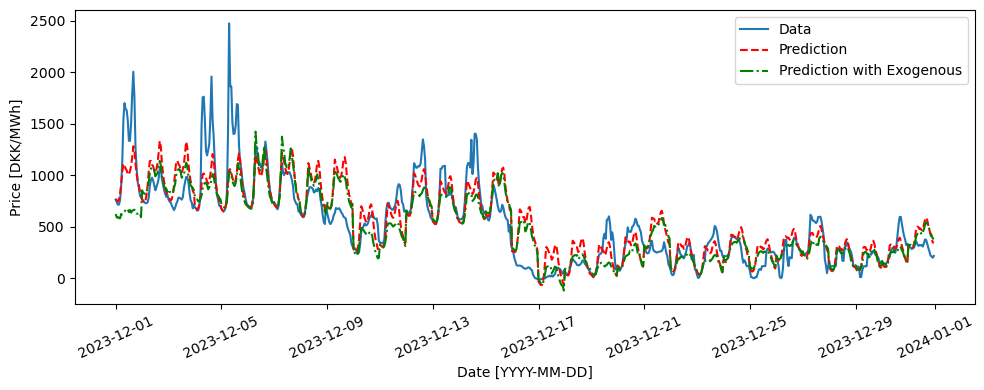

In [ ]:
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(test['HourUTC'], test_Arima, label='Data')
plt.plot(test['HourUTC'], pred, label='Prediction', linestyle="dashed", color="red")
plt.plot(test['HourUTC'], pred_exog, label='Prediction with Exogenous', linestyle="dashdot", color="green")

plt.legend()
plt.ylabel('Price [DKK/MWh]')
plt.xlabel('Date [YYYY-MM-DD]')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

Calculating error metrics

In [ ]:
RMSE_AR_pred = sqrt(mean_squared_error(test_Arima, pred_exog))
MAE_AR_pred = mean_absolute_error(test_Arima, pred_exog)
print('Prediction')
print('\t Root-mean-square error: ', round(RMSE_AR_pred,2))
print('\t Mean absolute error: ', round(MAE_AR_pred,2))

Prediction
	 Root-mean-square error:  240.95
	 Mean absolute error:  159.23
